In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import operator

# pyro imports
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoMultivariateNormal

import os
import sys
sys.path.append("../src") if "../src" not in sys.path else None 

# custom imports
from methods import *
from mnd import *
from evaluation import * 

### Initialize Data

In [3]:
# choose dataset to use
dataset_name = 'yacht.txt'#'energy_heating_load.txt'#
datasets_path = '../datasets/'
dataset_path = datasets_path + dataset_name

# load data and create torch training data loader
(X_train, y_train), (X_test, y_test) = load_data(dataset_path)
trainloader = torch.utils.data.DataLoader(Dataset(X_train, y_train, dataset_name.split('.')[0], normalize=True), 
                                         batch_size:=128, shuffle:=True)

In [4]:
net = MND_BNN_alternative(input_size:=X_train.shape[-1], hidden_size:=input_size, output_size:=1)

### Dev

In [5]:
def train(svi, train_loader, batch_size, use_cuda=False):
    epoch_loss = 0.
    
    for i, (X, y) in enumerate(train_loader):
        epoch_loss += svi.step(X,y)
        
    N = len(train_loader.dataset)
    return epoch_loss / N

def evaluate(svi, test_loader, batch_size, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
        
    N = len(test_loader.dataset)
    return test_loss / N

In [11]:
# clear param store
# pyro.clear_param_store()

# setup the optimizer
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(net.model, net.guide, optimizer, loss=Trace_ELBO())
# svi = SVI(net.model, AutoMultivariateNormal(net.model), optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS:=5000):
    total_epoch_loss_train = train(svi, trainloader, batch_size)
    train_elbo.append(-total_epoch_loss_train)
    if not (epoch % 100):
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    """
    # report test diagnostics
    total_epoch_loss_test = evaluate(svi, test_loader, batch_size)
    test_elbo.append(-total_epoch_loss_test)
    print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
    """
    #torch.Size([128, 7]) torch.Size([128, 7, 6])

[epoch 000]  average training loss: 1057.9341
[epoch 100]  average training loss: 814.7787
[epoch 200]  average training loss: 721.4867
[epoch 300]  average training loss: 676.3544
[epoch 400]  average training loss: 597.7935
[epoch 500]  average training loss: 557.8325
[epoch 600]  average training loss: 521.0292
[epoch 700]  average training loss: 454.4817
[epoch 800]  average training loss: 406.7376
[epoch 900]  average training loss: 367.5668
[epoch 1000]  average training loss: 327.8114
[epoch 1100]  average training loss: 278.9520
[epoch 1200]  average training loss: 248.9737
[epoch 1300]  average training loss: 238.0844
[epoch 1400]  average training loss: 224.3229
[epoch 1500]  average training loss: 207.6139
[epoch 1600]  average training loss: 183.7218
[epoch 1700]  average training loss: 170.9185
[epoch 1800]  average training loss: 150.5002
[epoch 1900]  average training loss: 155.5447
[epoch 2000]  average training loss: 139.6271
[epoch 2100]  average training loss: 140.70

In [12]:
# do predictions
Lpi, Upi, mu_posterior, mu_pred = net.monte_carlo_PI(trainloader.dataset[:][0], nsamples=50, percentile=0.95)

# invert prediction normalization
invert_normalization = lambda y: y * trainloader.dataset.stdy + trainloader.dataset.muy
Lpi, Upi, mu_posterior, mu_pred, y_true = map(invert_normalization, \
                                        (Lpi, Upi, mu_posterior, mu_pred, trainloader.dataset[:][1]))

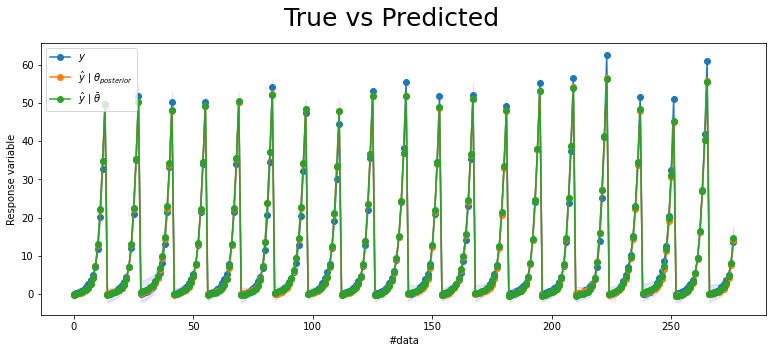

In [14]:
# plotting
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(y_true, "-o", label="$y$")
ax.plot(mu_posterior[:,0], "-o", label="$\\hat{y} \\mid \\theta_{posterior}$")
ax.plot(mu_pred[:,0], "-o", label="$\\hat{y} \\mid \\bar{\\theta}$")
#ax.plot(preds, "-o", label="$\hat{y}$")
ax.set_xlabel("#data")
ax.set_ylabel("Response variable")
ax.legend()
fig.suptitle("True vs Predicted", size=25)
ax.fill_between(np.arange(len(y_train)), Lpi[:,0], Upi[:,0], color='b', alpha=.1)

In [16]:
# evaluate model
print(f"{rmse(y_true, mu_posterior)=}, {picp(Lpi, Upi, y_true)=}, {mpiw(Lpi, Upi)=}")

rmse(y_true, mu_posterior)=1.1398442, picp(Lpi, Upi, y_true)=0.9097472924187726, mpiw(Lpi, Upi)=3.590599


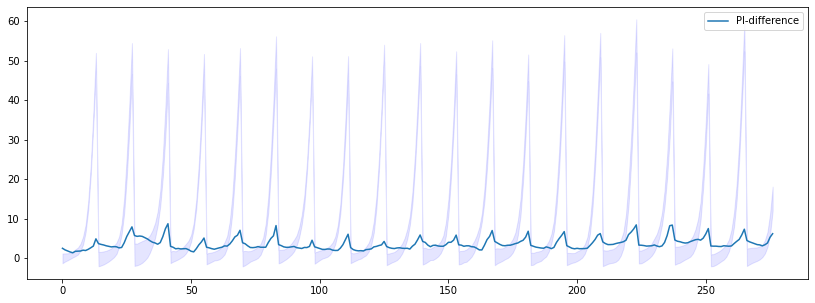

In [17]:
# Plot uncertainty curve and PI difference
# - We expect the PI to be wider where there is few data points, i.e. at the peaks of the "yatch.txt" 
# dataset, but the plot above does not seem to support this fact. However, when the graph "grows"
# quickly, the PI width appears thin, while it in reality is actually wider. 
# This can be seen from the follow plot: I.e. that the PI difference grows near the peaks, and
# becomes smaller near the troughs.
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(Upi[:,0] - Lpi[:,0], label='PI-difference')
ax.fill_between(np.arange(len(y_train)), Lpi[:,0], Upi[:,0], color='b', alpha=.1)
ax.legend()

In [ ]:
net.sample_weights()

In [ ]:
for key, value in pyro.get_param_store().items():
    print(key, value)

In [ ]:
_,tril_cov1,_,tril_cov2,_,_ = pyro.get_param_store().values()

In [ ]:
print(np.around((tril_cov1.T @ tril_cov1).detach().numpy(),decimals=3))
print(np.around((tril_cov2.T @ tril_cov2).detach().numpy(),decimals=3))